In [3]:
import dynamo as dyn
import pandas as pd
import numpy as np
import warnings
import scanpy as sc
import random

SEED = 2024
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# adata_hsc_raw = dyn.sample_data.hematopoiesis_raw()
# adata_hsc_raw
# "https://www.dropbox.com/s/rvkxvq8694xnxz3/hsc_raw_with_metadata.h5ad?dl=1"

In [3]:
adata_hsc_raw = sc.read_h5ad('/media/liyaru/LYR/Diff_change/2_benchmark/1_dynamo/data/hsc_raw_with_metadata.h5ad')
adata_hsc_raw

AnnData object with n_obs × n_vars = 1947 × 26193
    obs: 'batch', 'cell_type', 'time'
    var: 'gene_name_mapping'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced'

In [4]:
selected_genes_to_use = adata_hsc_raw.uns["genes_to_use"]
preprocessor = dyn.pp.Preprocessor(force_gene_list=selected_genes_to_use)
preprocessor.config_monocle_recipe(adata_hsc_raw, n_top_genes=len(selected_genes_to_use))
preprocessor.preprocess_adata_monocle(
    adata_hsc_raw,
    tkey="time",
    experiment_type="one-shot",
)


|-----> Running monocle preprocessing pipeline...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


4 input query terms found dup hits:	[('ENSG00000230373', 2), ('ENSG00000249738', 2), ('ENSG00000278903', 3), ('ENSG00000287838', 2)]
78 input query terms found no hit:	['ENSG00000112096', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000203812', 'ENSG00000205485', 'ENS


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.
|-----------> filtered out 0 outlier cells
|-----------> filtered out 18815 outlier genes
|-----> OVERWRITE all gene selection results above according to user gene list inputs. 2115 genes in use.
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [73.9305s]


In [5]:
adata_hsc_raw.var.use_for_pca.sum()

1750

In [6]:
dyn.tl.reduceDimension(adata_hsc_raw)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [0.1126s]


In [7]:
dyn.tl.moments(adata_hsc_raw, group="time")

|-----> calculating first/second moments...
|-----> [moments calculation] completed [14.1208s]


In [8]:
adata_hsc_raw.uns["pp"]["has_splicing"] = False
dyn.tl.dynamics(adata_hsc_raw, group="time", one_shot_method="sci_fate", model="deterministic")

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] completed [3.2661s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1750/1750 [00:00<00:00, 67134.03it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] completed [2.2793s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1750/1750 [00:00<00:00, 64633.44it/s]


AnnData object with n_obs × n_vars = 1947 × 21705
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b

In [9]:
pca_genes = adata_hsc_raw.var.use_for_pca
new_expr = adata_hsc_raw[:, pca_genes].layers["M_n"]
time_3_gamma = adata_hsc_raw[:, pca_genes].var.time_3_gamma.astype(float)
time_5_gamma = adata_hsc_raw[:, pca_genes].var.time_5_gamma.astype(float)

t = adata_hsc_raw.obs.time.astype(float)
M_s = adata_hsc_raw.layers["M_s"][:, pca_genes]

time_3_cells = adata_hsc_raw.obs.time == 3
time_5_cells = adata_hsc_raw.obs.time == 5

In [10]:
def alpha_minus_gamma_s(new, gamma, t, M_s):
    # equation: alpha = new / (1 - e^{-rt}) * r
    alpha = new.A.T / (1 - np.exp(-gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]

    gamma_s = gamma.values[:, None] * M_s.A.T
    alpha_minus_gamma_s = alpha - gamma_s
    return alpha_minus_gamma_s

time_3_velocity_n = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma, t[time_5_cells], M_s[time_5_cells, :])

velocity_n = adata_hsc_raw.layers["velocity_N"].copy()

valid_velocity_n = velocity_n[:, pca_genes].copy()
valid_velocity_n[time_3_cells, :] = time_3_velocity_n.T
valid_velocity_n[time_5_cells, :] = time_5_velocity_n.T
velocity_n[:, pca_genes] = valid_velocity_n.copy()

adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"] = velocity_n.copy()

In [11]:
dyn.tl.cell_velocities(
    adata_hsc_raw,
    enforce=True,
    X=adata_hsc_raw.layers["M_t"],
    V=adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
)

|-----> 178 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [218.2904s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.7588s]


AnnData object with n_obs × n_vars = 1947 × 21705
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b

In [2]:
help(dyn.tl.cell_velocities)

Help on function cell_velocities in module dynamo.tools.cell_velocities:

cell_velocities(adata: anndata._core.anndata.AnnData, ekey: Union[str, NoneType] = None, vkey: Union[str, NoneType] = None, X: Union[<built-in function array>, scipy.sparse._csr.csr_matrix, NoneType] = None, V: Union[<built-in function array>, scipy.sparse._csr.csr_matrix, NoneType] = None, X_embedding: Union[numpy.ndarray, NoneType] = None, transition_matrix: Union[numpy.ndarray, scipy.sparse._csr.csr_matrix, NoneType] = None, use_mnn: bool = False, n_pca_components: Union[int, NoneType] = None, transition_genes: Union[str, List[str], List[bool], NoneType] = None, min_r2: Union[float, NoneType] = None, min_alpha: Union[float, NoneType] = None, min_gamma: Union[float, NoneType] = None, min_delta: Union[float, NoneType] = None, basis: str = 'umap', neighbor_key_prefix: str = '', adj_key: str = 'distances', add_transition_key: str = None, add_velocity_key: str = None, n_neighbors: int = 30, method: Literal['kmc', '

|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


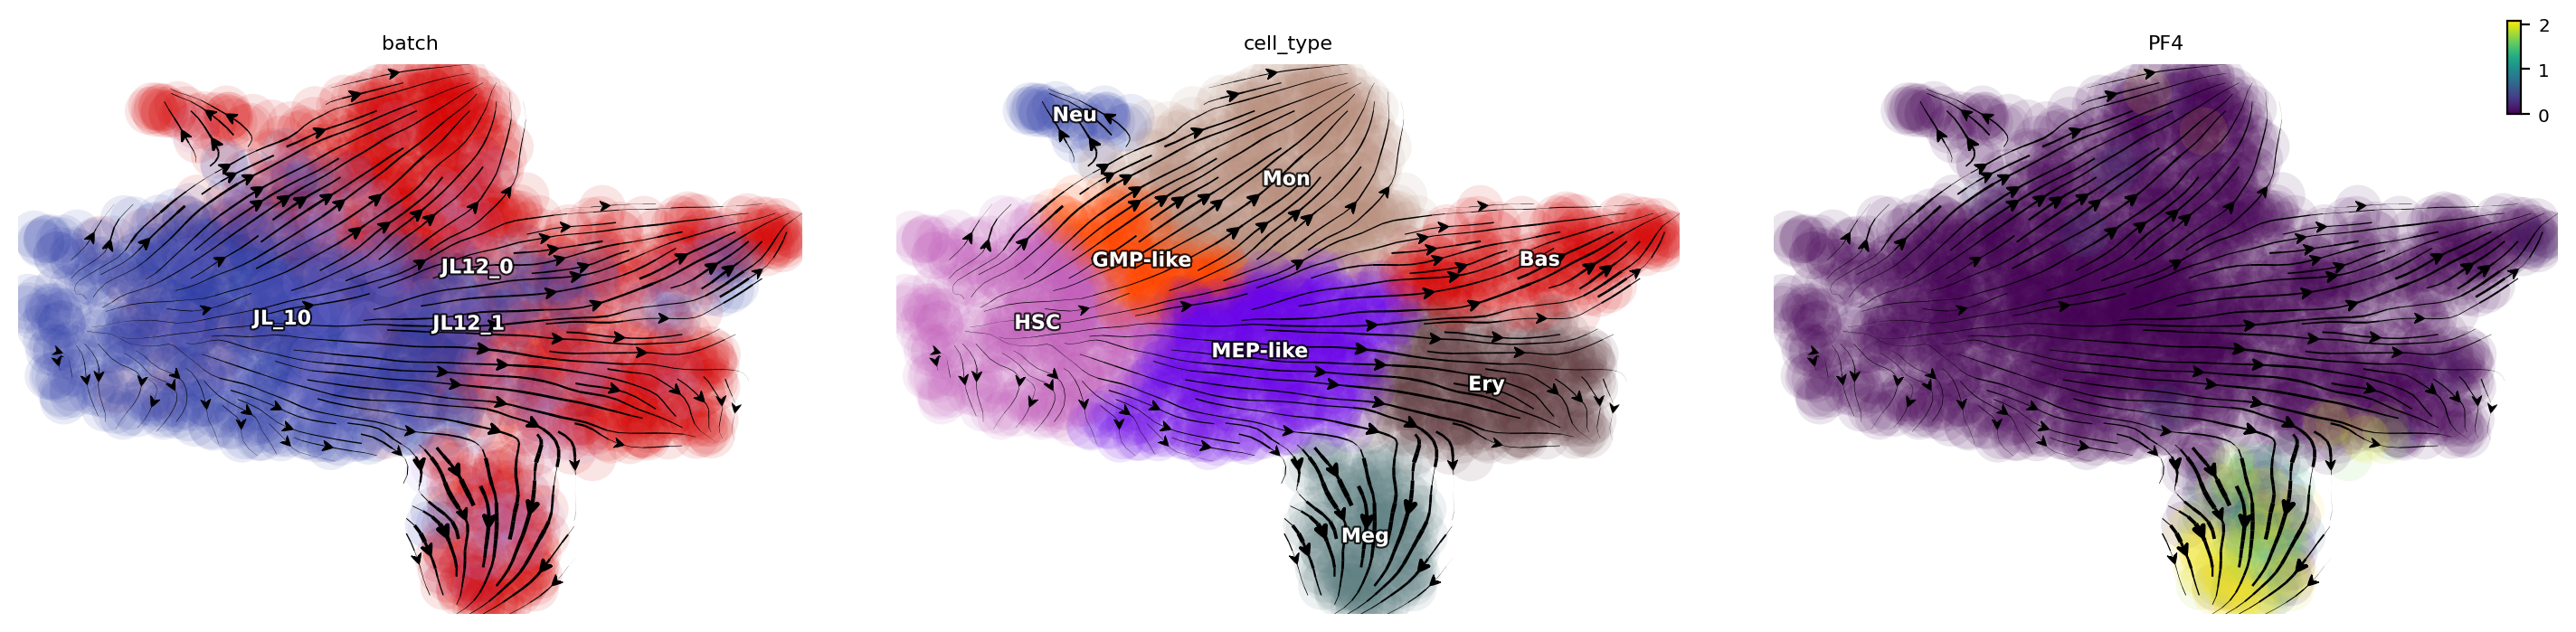

In [12]:
dyn.pl.streamline_plot(
    adata_hsc_raw,
    color=["batch", "cell_type", "PF4"],
    ncols=3,
    basis="umap")

In [22]:
dyn.pl.streamline_plot(
    adata_hsc_raw,
    color="cell_type",
    ncols=4,
    basis="umap",
    save_show_or_return = 'save',
    color_key = sc.pl.palettes.default_20,
    show_legend = "right",
    save_kwargs = {"path":"/media/liyaru/LYR/Diff_change/8_dynamo_Data/Figure/stream/" , 
                   "prefix": "dynamo_scNT",
                   "dpi": 300, 
                   "ext": "svg"} 
)

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/Diff_change/8_dynamo_Data/Figure/stream/dynamo_scNT_dyn_savefig.svg...
Done


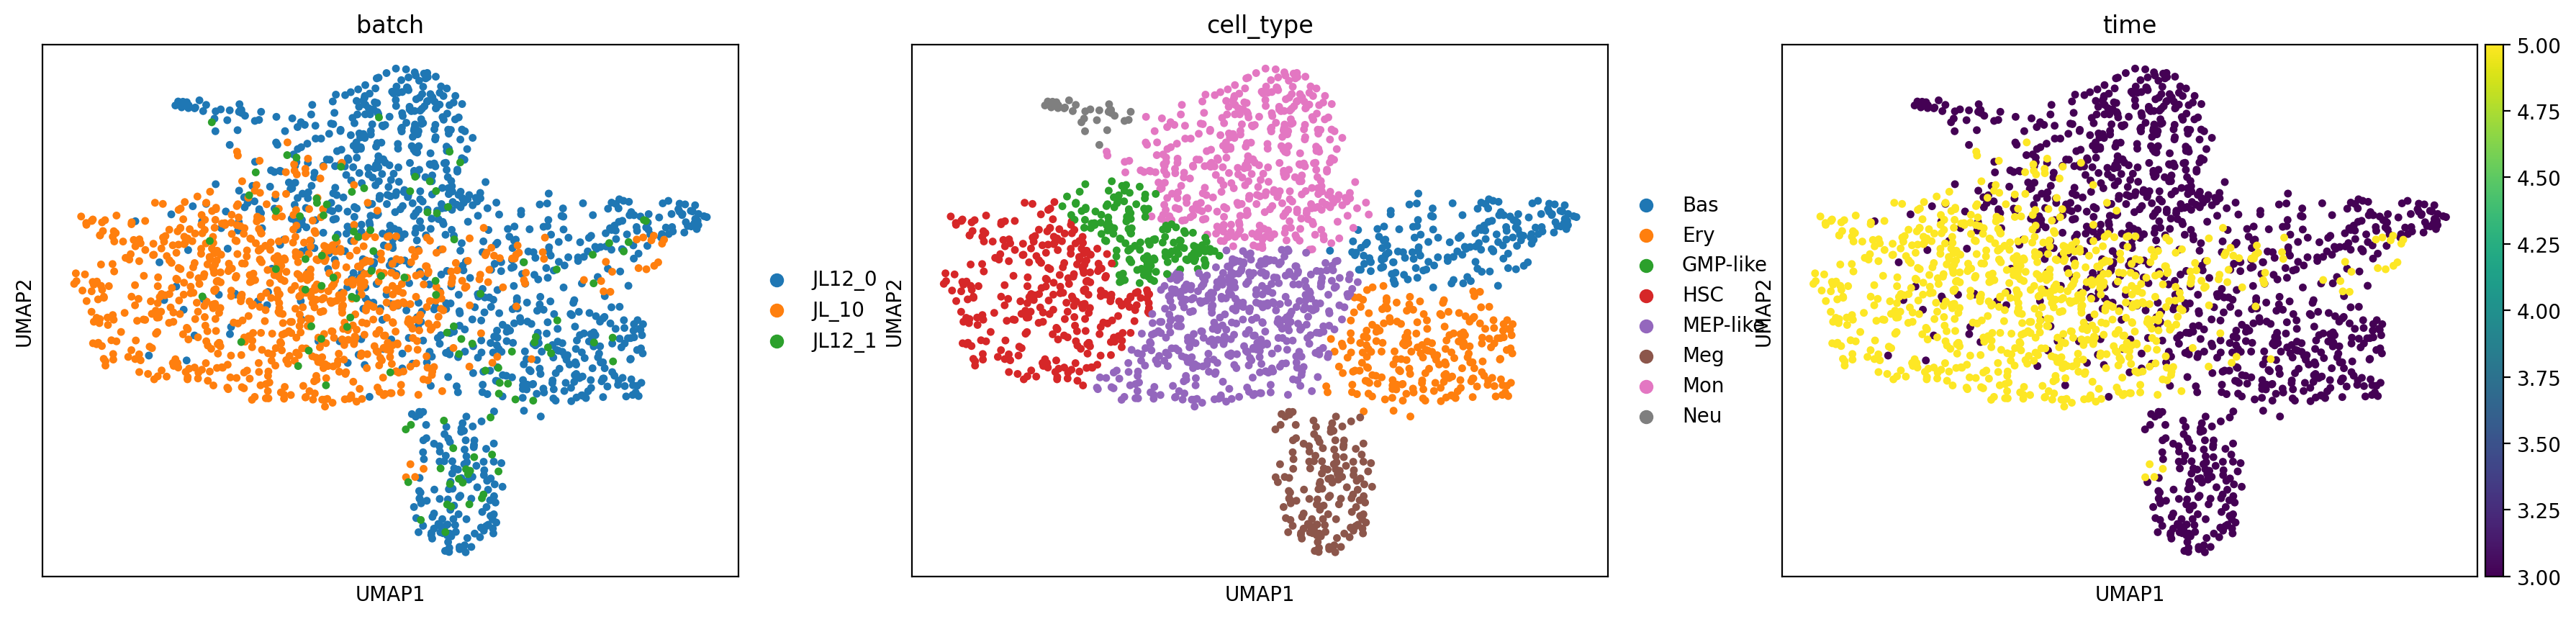

In [14]:
sc.pl.umap(adata_hsc_raw, color=['batch', 'cell_type', 'time'])

In [15]:
v = adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"].toarray()
# cols_to_keep = np.any(v != 0, axis=0)
np.save("/media/liyaru/LYR/Diff_change/8_dynamo_Data/scNT_HSC_v.npz",v)

In [16]:
# adata_hsc_raw.obs = adata_hsc_raw.obs.iloc[:,0:10]
adata_hsc_raw.var = adata_hsc_raw.var.iloc[:,0:10]
adata_hsc_raw.write_h5ad("/media/liyaru/LYR/Diff_change/8_dynamo_Data/scNT_HSC.h5ad")